## Notebook 02 (Project 03)

---

### **1. Recap and Motivation**


In the previous notebook (**NB01: Multiclass Classification Foundations**), we laid the theoretical groundwork for understanding multiclass classification. Here's a quick recap of what we covered:

> **What Did We Learn in NB01?**

- We explored the **Yeast protein localization dataset**, where the goal is to predict **where a protein is localized inside a cell** (e.g., mitochondria, nucleus, cytoplasm).
- We analyzed:
  - Feature distributions across classes
  - Class imbalance using bar plots
  - Correlation structure among features
- We introduced key concepts for multiclass classification:
  - **Softmax activation**, which turns raw scores (logits) into probability distributions.
  - **Cross-entropy loss**, which quantifies the gap between predicted probabilities and the true class.
  - **Evaluation metrics** for multiclass settings like accuracy, precision, recall, F1-score, and confusion matrix.

> **What Are We Doing in This Notebook?**

This notebook focuses on building and training a **feedforward neural network** to solve the multiclass classification task on the **Yeast dataset**.

Specifically, we will:

1. Prepare the Yeast data for training in PyTorch (splitting, scaling, encoding).
2. Define a neural network model using `torch.nn.Sequential`.
3. Train the model using cross-entropy loss and an optimizer like Adam.
4. Track training progress with a **loss curve**.
5. Evaluate model performance using accuracy and confusion matrix.

>**Why This Step Is Important**

Building the first real model from scratch lets us:

- Put all the theory into action.
- See how the softmax + cross-entropy combo performs in practice.
- Begin thinking about **generalization** — can the model perform well on **unseen test data**?

➡️ In the next section, we’ll reload the Yeast dataset and get it ready for training. Let’s begin!

---

### **2. Data Preparation**

Before we can train a neural network, we need to **prepare our data**:

> **Recap of the Dataset**

We’re working with the **Yeast dataset**, where:
- Each protein sample is described using **8 numerical features** (like `mcg`, `gvh`, `alm`, etc.)
- The target label (`localization_site`) is **categorical** with multiple classes such as:
  - `MIT` (Mitochondria)
  - `NUC` (Nucleus)
  - `CYT` (Cytoplasm)
  - `ME3`, `EXC`, etc.

>**Preparation Steps**

We’ll now:
1. Load the dataset.
2. Encode the target label as **numerical integers** (for PyTorch training).
3. Standardize all features using **`StandardScaler`** to zero mean and unit variance.
4. Split the dataset into **training and test sets**.
5. Convert everything to **PyTorch tensors**.

>**Why Standardization Matters**

Neural networks learn by adjusting weights based on gradients — changes in the loss with respect to input values. If one feature (say, mcg) ranges from 0 to 1, and another (vac) ranges from 0 to 1000, the network might focus more on the large-scale feature, simply because its values dominate the computation. This can cause:

- Unstable gradients: Larger input values may lead to exploding or vanishing gradients during backpropagation.

- Slower convergence: The optimizer has to work harder to balance updates across differently scaled features.

- Poor performance: The network may get stuck in suboptimal solutions or take longer to generalize well.

✅ Standardization brings all features to a similar scale (mean = 0, std = 1), which makes learning smoother, faster, and more reliable — especially when using gradient-based optimizers like SGD or Adam.

So, we standardize to bring all features to the same scale.

Let’s jump into the code!

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

# 1. Load the yeast dataset (already cleaned and merged in NB01)
df = pd.read_csv("yeast.csv")  # Replace with your file path if needed

# 2. Separate features and target
X = df.drop(columns=["localization_site"])
y = df["localization_site"]

# 3. Encode target labels as integers (e.g., MIT → 0, NUC → 1, etc.)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train/test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 6. Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# 7. Check dimensions
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Number of classes:", len(label_encoder.classes_))

Train set size: torch.Size([1187, 8])
Test set size: torch.Size([297, 8])
Number of classes: 10


**What Did We Do?**

- Encoded target labels into integers: essential for PyTorch’s classification loss functions.
- Standardized all features: ensures the model trains stably.
- Created training and test sets: with **stratified sampling** to preserve class ratios.
- Converted everything into **`torch.tensor`** format so we can feed them into the network.

📌 Now that our data is ready, it’s time to **define and build our neural network model**!

---

### **3. Model Architecture**

**🎯 Goal:** Define a simple feedforward neural network (Multilayer Perceptron) using `torch.nn`.

> **What Are We Building?**

We’re designing a **Multiclass Classifier** that maps **8 input features** to **10 output classes** (protein localization sites).  
We’ll start with a **basic MLP**:

- **Input layer**: 8 features  
- **Hidden layer**: 16 neurons (ReLU activation)  
- **Output layer**: 10 neurons — one per class

We use `nn.CrossEntropyLoss`, so the final output layer **must NOT have softmax** — PyTorch applies it internally during loss computation.

> **Architecture Summary**

- `Input → Linear(8 → 16) → ReLU → Linear(16 → 10)`
- Activation: ReLU in the hidden layer
- Output layer: Raw logits (passed to CrossEntropyLoss)

> **Why This Architecture?**

- **ReLU** avoids vanishing gradients and introduces non-linearity.
- **16 hidden units** give the model enough capacity without overfitting on this small dataset.
- **10 outputs** match the number of target classes in the Yeast dataset.

We’ll explore how model complexity affects learning in the next notebook.

In [3]:
import torch
import torch.nn as nn

# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Linear(8, 16),      # input layer to hidden layer
    nn.ReLU(),             # non-linearity
    nn.Linear(16, 10)      # hidden layer to output layer (10 classes)
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=10, bias=True)
)



➡️ In the next section, we’ll define the **training loop**: forward pass → loss → backward pass → weight update.

---

### **4. Training Loop**

**🎯 Goal:** Train our MLP model using a standard supervised learning loop in PyTorch.

>**The Training Workflow**

Training a neural network involves the following cycle for each epoch:

1. **Forward Pass**: Compute predicted outputs (`logits`) from the model.
2. **Loss Computation**: Compare predictions against the true labels using a loss function.
3. **Backward Pass**: Compute gradients of the loss w.r.t. model parameters.
4. **Parameter Update**: Adjust the weights using an optimizer like SGD or Adam.
5. **Repeat** for multiple epochs to minimize the loss.


>Loss Function: `CrossEntropyLoss`

For multiclass classification, we use: $$\text{Loss} = -\log \left( \frac{e^{z_{\text{true class}}}}{\sum_j e^{z_j}} \right)$$

- Input: **Raw logits** from model (not softmaxed)
- Target: Class indices (e.g., 0–9 for 10 classes)

>Optimizer: `torch.optim.Adam`

Adam combines momentum and adaptive learning rate for efficient training.  
We don’t tune hyperparameters here — we’ll discuss optimizers more deeply in the next notebook.

>Training Tips

- **Shuffle** the data during training (`DataLoader` helps with this in future notebooks).
- Always **zero out gradients** before calling `.backward()`.
- Track **training accuracy** along with loss to assess learning progress.

In [4]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 200
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    # Forward pass
    logits = model(X_train)
    loss = criterion(logits, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record loss
    train_losses.append(loss.item())
    
    # Compute training accuracy
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y_train).sum().item()
    accuracy = correct / len(y_train)
    train_accuracies.append(accuracy)
    
    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.2f}%")


Epoch 10: Loss = 1.9263, Accuracy = 33.11%
Epoch 20: Loss = 1.5579, Accuracy = 42.63%
Epoch 30: Loss = 1.3011, Accuracy = 52.65%
Epoch 40: Loss = 1.1571, Accuracy = 56.61%
Epoch 50: Loss = 1.0948, Accuracy = 59.98%
Epoch 60: Loss = 1.0512, Accuracy = 61.16%
Epoch 70: Loss = 1.0252, Accuracy = 61.42%
Epoch 80: Loss = 1.0089, Accuracy = 62.01%
Epoch 90: Loss = 0.9973, Accuracy = 62.01%
Epoch 100: Loss = 0.9882, Accuracy = 62.26%
Epoch 110: Loss = 0.9805, Accuracy = 62.93%
Epoch 120: Loss = 0.9734, Accuracy = 62.51%
Epoch 130: Loss = 0.9670, Accuracy = 63.18%
Epoch 140: Loss = 0.9607, Accuracy = 63.69%
Epoch 150: Loss = 0.9547, Accuracy = 63.77%
Epoch 160: Loss = 0.9488, Accuracy = 63.94%
Epoch 170: Loss = 0.9432, Accuracy = 63.86%
Epoch 180: Loss = 0.9382, Accuracy = 64.28%
Epoch 190: Loss = 0.9332, Accuracy = 64.03%
Epoch 200: Loss = 0.9293, Accuracy = 64.53%


➡️ Next, we’ll track loss and accuracy over epochs to better visualize model learning.

---

### **5. Track and Plot Training Metrics**

**🎯 Goal:** Visualize how our model’s loss and accuracy evolve over training epochs.

> Why Plot Training Curves?

Monitoring **loss** and **accuracy** over time helps us:

- Understand if the model is **learning effectively**.
- Detect problems like **underfitting** (loss not decreasing) or **overfitting** (accuracy peaks then drops).
- Evaluate the impact of learning rate, architecture, and dataset complexity.

>What We’re Tracking?

- **Loss**: Measures how far predictions are from true labels. We want it to **decrease**.
- **Accuracy**: Percentage of correctly classified samples. We want it to **increase**.

These metrics were already recorded in the training loop using `train_losses` and `train_accuracies`.

>What We Hope to See

- A **smoothly decreasing loss curve**.
- An **increasing accuracy curve** that gradually levels off.
- No wild oscillations or plateaus — which would suggest learning issues.

Let’s plot the metrics!

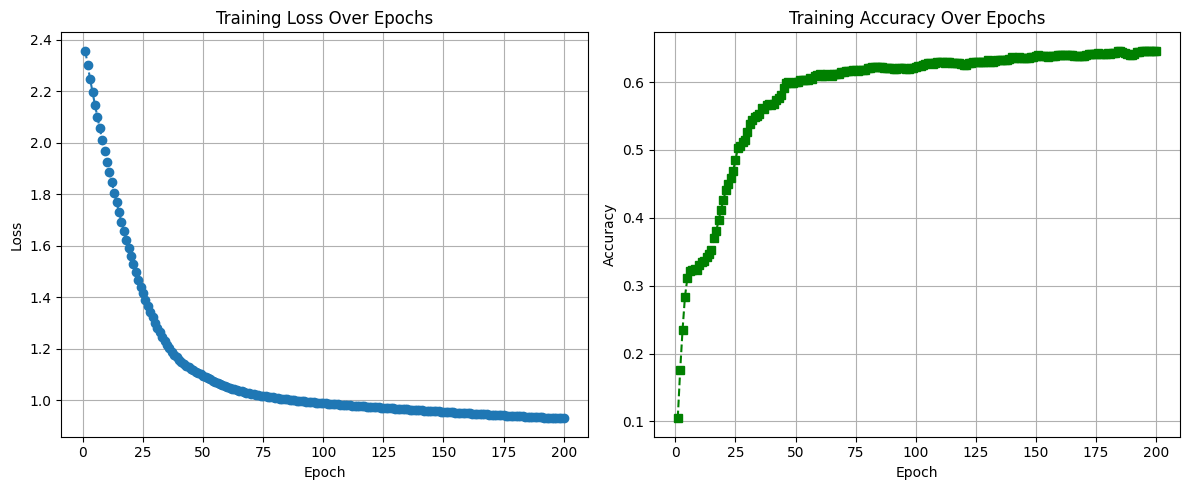

In [5]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='--')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='s', linestyle='--', color='green')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


>**Interpreting the Training Curves**

>Training Loss Curve (Left Plot)
- The loss **decreases steadily**, especially in the early epochs.
- After about 100 epochs, it begins to **flatten**, indicating the model is approaching a minimum.
- This is a healthy trend — it shows the model is learning and **optimizing its parameters** effectively.

>Training Accuracy Curve (Right Plot)
- Accuracy **rises quickly** in the first few epochs — a good sign of rapid learning.
- It then continues to improve gradually, stabilizing after ~100 epochs.
- The final training accuracy is around **65%**, which gives us a baseline before testing on unseen data.

>Key Takeaways
- The **loss and accuracy curves** tell a **coherent story** — the model is learning and getting better at classification.
- There's no clear sign of **overfitting yet**, since we haven't evaluated on the test set — that's coming up next.
- The **gap between loss and accuracy** reminds us that minimizing loss doesn't always mean perfect classification — especially in multiclass settings.

➡️ In the next section, we’ll evaluate the model’s performance on **unseen test data**, using both accuracy and a confusion matrix to better understand where it performs well (or struggles).

---

### **6. Model Evaluation on Test Set**

Now that we’ve trained our feedforward neural network on the Yeast dataset,  
it’s time to **evaluate how well it generalizes** to unseen data.

We’ll measure:

- **Overall Accuracy**: Proportion of correct predictions on the test set.
- **Confusion Matrix**: A matrix that shows how often each class is predicted correctly or confused with others.
- **Per-Class Performance**: Especially important in multiclass settings, where class imbalance can skew overall metrics.

>Why Go Beyond Accuracy?

In multiclass classification tasks with **unequal class frequencies**, accuracy can be misleading.

For example:
- If 50% of the data belongs to Class A, a model that predicts “Class A” always will have **50% accuracy** — but that doesn’t mean it learned anything useful.

That’s why we also use the **confusion matrix**, which shows us:
- Which classes are hardest to predict
- Where the model is most confused
- Whether rare classes are ignored

Let’s now compute these metrics using `scikit-learn`.

Test Accuracy: 0.5960


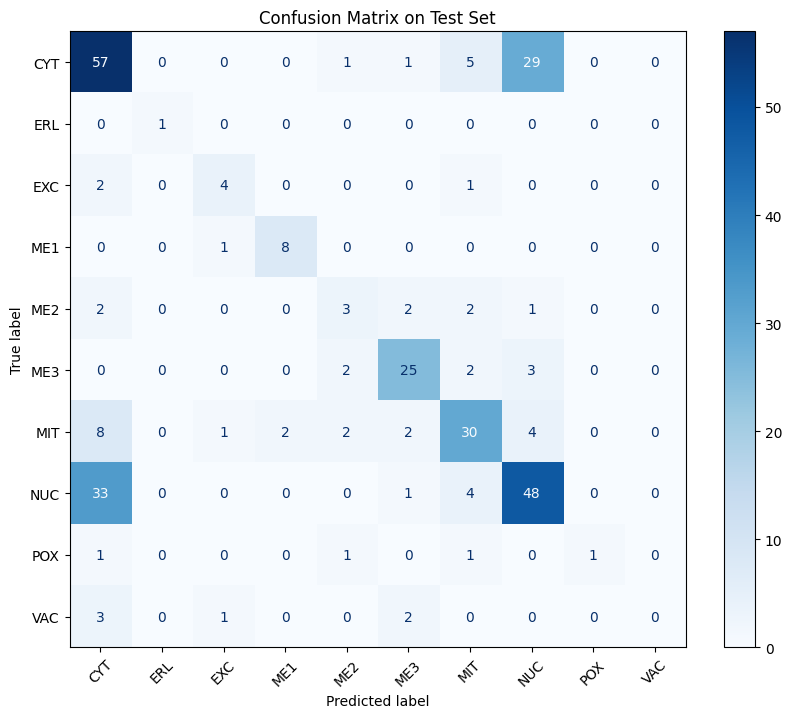

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ----- Predict on test data -----
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_labels = torch.argmax(y_pred_logits, dim=1).cpu().numpy()

# ----- Convert ground truth to numpy -----
y_test_np = y_test.cpu().numpy()

# ----- Accuracy -----
acc = accuracy_score(y_test_np, y_pred_labels)
print(f"Test Accuracy: {acc:.4f}")

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test_np, y_pred_labels)

# Assuming you used LabelEncoder before
from sklearn.preprocessing import LabelEncoder

# Re-create encoder and fit to original labels if needed
encoder = LabelEncoder()
encoder.fit(df['localization_site'])  # Ensure same order as before
class_names = encoder.classes_

# Display with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


Each row represents the **true class**, and each column the **predicted class**.

- **Diagonal cells** represent **correct predictions** — higher values here mean the model is more accurate for that class.
- **Off-diagonal entries** reflect **misclassifications** — showing which classes are being confused.

> Key Observations:

- The model is doing **reasonably well** for high-frequency classes like:
  - `CYT` (57 correct) and `NUC` (45 correct), although `NUC` shows heavy confusion (37 times predicted as `CYT`).
  - `ME3` and `MIT` also have substantial correct predictions.

- **Heavy confusion from `NUC` → `CYT`**:  
  A large number of `NUC` examples are incorrectly predicted as `CYT`, suggesting possible overlap or bias in learned representations.

- **Rare classes** like `POX`, `EXC` have poor performance:
  `POX` and `EXC` often misclassified as majority classes.

- **Smaller classes** like `ME2`, `ME3` show **mixed** performance with frequent off-diagonal entries.

>**What This Tells Us**:

- The model is **skewed toward majority classes** — a classic symptom of class imbalance.
- While the model has learned useful features (e.g., for `CYT`, `MIT`, `ME3`), it struggles with generalizing to underrepresented classes.

➡️ Next, we’ll reflect on class imbalance more explicitly and how it affects model performance.

---

### **7. Class Imbalance Reflection**

In real-world datasets, class distributions are often **not uniform** — some classes may appear far more frequently than others.  
This situation is known as **class imbalance**.

Let’s revisit our Yeast dataset:

- Majority classes: `CYT`, `NUC`, `MIT`
- Minority classes: `ERL`, `POX`, `EXC`, `ME1`, `ME2`

>Why Does This Matter?

When we train a model on an imbalanced dataset:

- It tends to **optimize for overall accuracy**, which favors majority classes.
- The model may **ignore minority classes** altogether because they don’t contribute much to loss.
- Result: **High overall accuracy**, but poor recall for rare categories.

> **Intuition**: A model trained on this data may learn:
> “It’s safest to guess `CYT` or `NUC` — I’ll be right more often.”

This is **not desirable**, especially in **biological applications** where detecting rare categories (e.g., targeting organelles) might be critical.

>Metrics Also Mislead

- **Accuracy alone** becomes misleading in imbalanced settings.
- Instead, we need to examine:
  - **Precision**: Are predictions for class A correct?
  - **Recall**: Are all actual class A instances detected?
  - **F1 Score**: Balance between precision and recall

> What Can We Do?

There are some **practical strategies** that we can apply (however those are beyond scope of this NB):

- **Class weighting**: Penalize errors more for minority classes
- **Resampling**: Undersample majority or oversample minority
- **Synthetic generation**: e.g., SMOTE or data augmentation
- **Model strategies**: Deeper networks or focal loss

📌 **Bottom Line**: Class imbalance is a **fundamental modeling challenge**. Ignoring it can lead to **misleading model performance** and poor generalization.

---

### **8. Wrap-Up and Forward Pointer**

In this notebook, we took our first **full modeling step** for a multiclass classification task using the **Yeast protein localization dataset**.

We built, trained, and evaluated a basic **Multilayer Perceptron (MLP)** using PyTorch — and explored how it behaves on real-world, imbalanced biological data.

>What We Did

- Defined a simple MLP architecture with one hidden layer.
- Used `CrossEntropyLoss` to handle multiclass outputs (softmax under the hood).
- Tracked and plotted **loss** and **accuracy** to monitor training progress.
- Evaluated on a test set using **confusion matrix** and **accuracy metrics**.
- Reflected on the challenges introduced by **class imbalance**.

>Key Takeaways

- Even a simple feedforward model can learn **useful patterns**, but struggles with **minority classes**.
- **Loss curves** and **accuracy plots** help us monitor learning.
- Confusion matrices provide **rich, class-wise diagnostics**.
- We must think beyond accuracy — especially with **imbalanced datasets**.